<a href="https://colab.research.google.com/github/ydabke/Rice-Classification/blob/main/Rice_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [149]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [150]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [151]:
data_df.dropna(inplace = True)
data_df.drop(['id'], axis = 1, inplace = True)
print(data_df.shape)

(18185, 11)


In [152]:
print(data_df["Class"].unique())
print(data_df["Class"].value_counts())

[1 0]
Class
1    9985
0    8200
Name: count, dtype: int64


In [153]:
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].max()

data_df.head()


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [154]:
x = np.array(data_df.iloc[:, :-1])
y = np.array(data_df.iloc[:, -1])

In [155]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [156]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5)

In [157]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [158]:
class dataset(Dataset):
  def __init__(self, x, y):
    self.x = torch.tensor(x, dtype = torch.float32).to(device)
    self.y = torch.tensor(y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

In [159]:
training_data = dataset(x_train, y_train)
validation_data = dataset(x_val, y_val)
testing_data = dataset(x_test, y_test)

In [160]:
train_dataloader = DataLoader(training_data, batch_size = 32, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(testing_data, batch_size = 32, shuffle = True)

In [161]:
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()

    self.input_layer = nn.Linear(x.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = MyModel().to(device)

In [162]:
summary(model, (x.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [163]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

In [164]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10
for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    ## Training and Validation
    for data in train_dataloader:

        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)

Epoch no. 1 Train Loss: 0.2432 Train Accuracy: 78.3644 Validation Loss: 0.0411 Validation Accuracy: 94.5381
Epoch no. 2 Train Loss: 0.1314 Train Accuracy: 97.4703 Validation Loss: 0.0187 Validation Accuracy: 98.2405
Epoch no. 3 Train Loss: 0.0633 Train Accuracy: 98.1224 Validation Loss: 0.0103 Validation Accuracy: 98.2038
Epoch no. 4 Train Loss: 0.0395 Train Accuracy: 98.3659 Validation Loss: 0.0071 Validation Accuracy: 98.3138
Epoch no. 5 Train Loss: 0.0295 Train Accuracy: 98.4916 Validation Loss: 0.0056 Validation Accuracy: 98.6437
Epoch no. 6 Train Loss: 0.0246 Train Accuracy: 98.6016 Validation Loss: 0.0048 Validation Accuracy: 98.5704
Epoch no. 7 Train Loss: 0.0218 Train Accuracy: 98.6173 Validation Loss: 0.0043 Validation Accuracy: 98.7170
Epoch no. 8 Train Loss: 0.0199 Train Accuracy: 98.6095 Validation Loss: 0.0039 Validation Accuracy: 98.6070
Epoch no. 9 Train Loss: 0.0188 Train Accuracy: 98.6409 Validation Loss: 0.0037 Validation Accuracy: 98.7537
Epoch no. 10 Train Loss: 0.0

In [165]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)
    batch_loss_test = criterion(prediction, labels).item()
    total_loss_test += batch_loss_test

    acc = ((prediction).round() == labels).sum().item()

    total_acc_test += acc

print("Accuracry: ", round(total_acc_test/testing_data.__len__() * 100, 4))

Accuracry:  98.4238


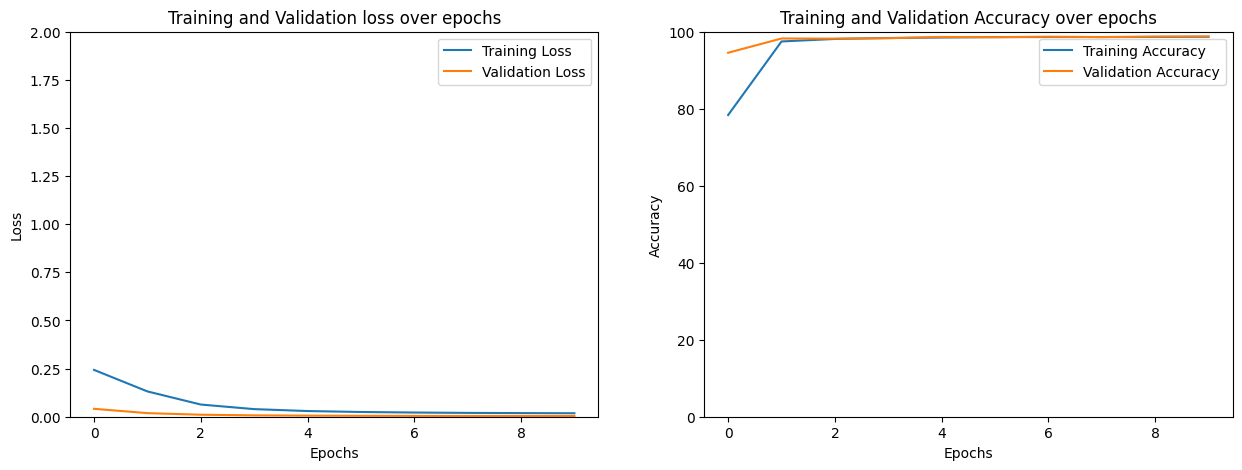

In [166]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Accuracy")
axs[1].plot(total_acc_validation_plot, label = "Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over epochs")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()